In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

Populating the interactive namespace from numpy and matplotlib


In [2]:
description, train, added_products, label_encoder, encoders = pickle.load(open('data/13.train_data.train_data', 'rb'))

time: 31.6 s


In [3]:
train.shape

(441652, 388)

time: 3.27 ms


In [54]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

time: 14.3 ms


In [5]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.752366
[1]	train-MAP@7:0.75667
[2]	train-MAP@7:0.760895
[3]	train-MAP@7:0.762945
[4]	train-MAP@7:0.763361
[5]	train-MAP@7:0.764287
[6]	train-MAP@7:0.765044
[7]	train-MAP@7:0.766386
[8]	train-MAP@7:0.768324
[9]	train-MAP@7:0.768472
[10]	train-MAP@7:0.768952
[11]	train-MAP@7:0.76933
[12]	train-MAP@7:0.769506
[13]	train-MAP@7:0.769812
[14]	train-MAP@7:0.770109
[15]	train-MAP@7:0.770437
[16]	train-MAP@7:0.770464
[17]	train-MAP@7:0.770677
[18]	train-MAP@7:0.770944
[19]	train-MAP@7:0.771053
[20]	train-MAP@7:0.771216
[21]	train-MAP@7:0.771365
[22]	train-MAP@7:0.771483
[23]	train-MAP@7:0.771639
[24]	train-MAP@7:0.771795
[25]	train-MAP@7:0.772017
[26]	train-MAP@7:0.772133
[27]	train-MAP@7:0.772255
[28]	train-MAP@7:0.77247
[29]	train-MAP@7:0.772645
[30]	train-MAP@7:0.772774
[31]	train-MAP@7:0.772916
[32]	train-MAP@7:0.772952
[33]	train-MAP@7:0.7731
[34]	train-MAP@7:0.773306
[35]	train-MAP@7:0.773344
[36]	train-MAP@7:0.773498
[37]	train-MAP@7:0.773639
[38]	train-MAP@7:0.773711
[

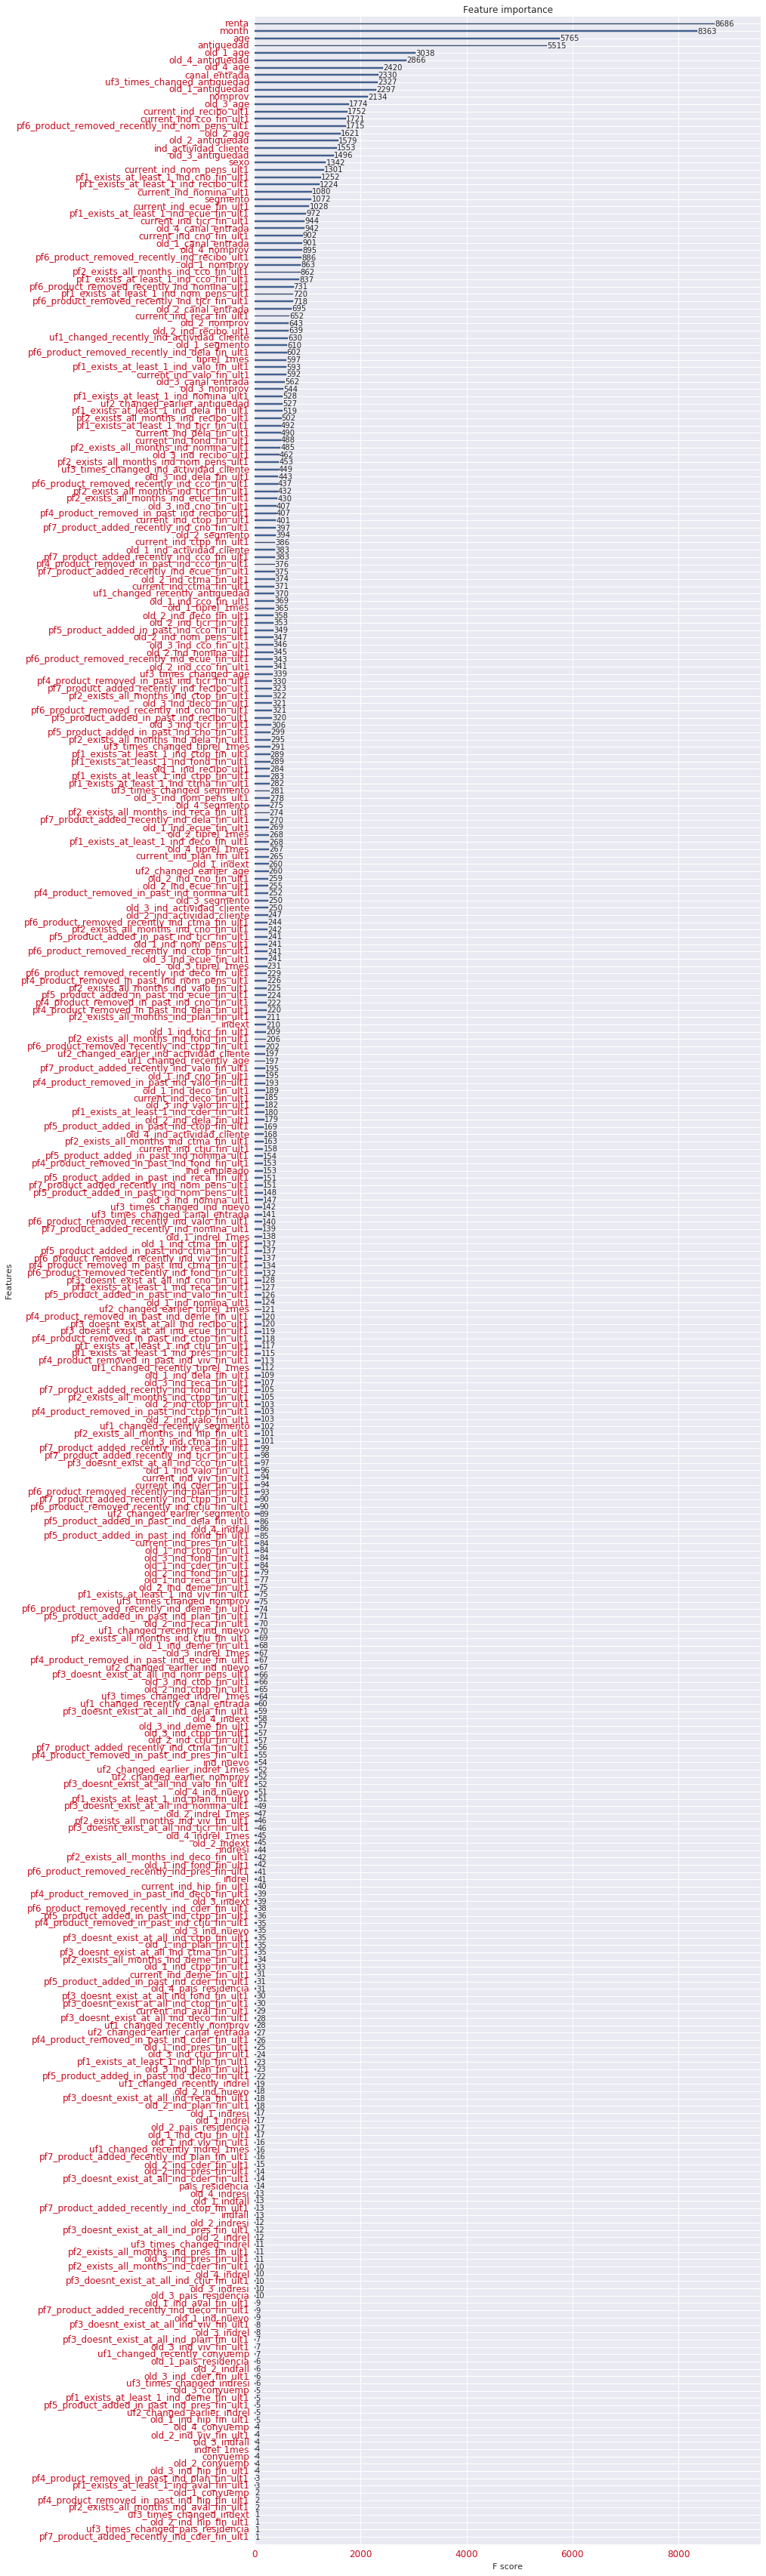

time: 6.82 s


In [6]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

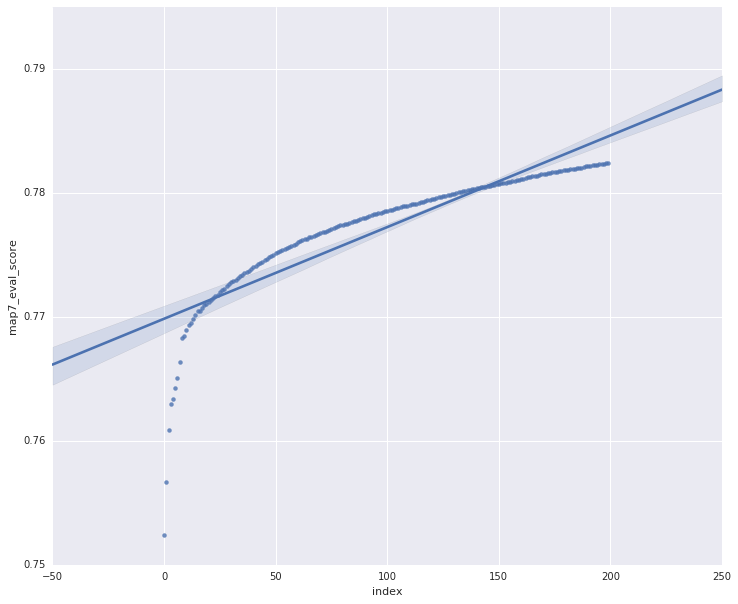

time: 907 ms


In [7]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [8]:
xgb_model.save_model('data/14.xgboost_model_save.xgb')
make_submission('data/14.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/14.xgboost_model_save.xgb.zip
uploading to s3 done
time: 1.31 s


In [40]:
description, test1 = pickle.load(open('data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)

time: 2.22 s


In [41]:
test1.tail()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,old_4_ind_actividad_cliente,old_4_segmento,old_4_pais_residencia,old_4_indrel,old_4_indresi,old_4_indext,old_4_conyuemp,old_4_indfall,old_4_nomprov,month
499995,351556,3,36,0,66,0.0,170.0,1.0,0,1,...,0.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,7.0,6
499996,628255,3,36,2,87,0.0,119.0,1.0,0,1,...,0.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,7.0,6
499997,208866,3,36,0,45,0.0,186.0,1.0,0,1,...,0.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
499998,1382539,3,36,2,47,0.0,16.0,1.0,0,0,...,1.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,7.0,6
499999,991912,3,36,0,36,0.0,54.0,1.0,0,1,...,0.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,8.0,6


time: 25.2 ms


In [34]:
test2.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,old_4_ind_actividad_cliente,old_4_segmento,old_4_pais_residencia,old_4_indrel,old_4_indresi,old_4_indext,old_4_conyuemp,old_4_indfall,old_4_nomprov,month
500000,208867,3,36,2,46,0.0,186.0,1.0,0,1,...,0.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
500001,208868,3,36,2,71,0.0,186.0,1.0,0,0,...,0.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
500002,1109642,3,36,2,35,0.0,42.0,1.0,0,1,...,0.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,7.0,6
500003,208873,3,36,2,48,0.0,186.0,1.0,0,0,...,1.0,0.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
500004,208879,3,36,0,46,0.0,186.0,1.0,0,0,...,1.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6


time: 24 ms


In [42]:
print test.shape
test.head()

(929615, 388)


,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,...,old_4_ind_actividad_cliente,old_4_segmento,old_4_pais_residencia,old_4_indrel,old_4_indresi,old_4_indext,old_4_conyuemp,old_4_indfall,old_4_nomprov,month
ncodpers,,,,,,,,,,,,,,,,,,,,,
869505,3,36,0,26,0.0,75.0,1.0,0,0,1,...,1.0,1.0,36.0,1.0,1.0,0.0,2.0,0.0,3.0,6
1477437,3,36,0,22,0.0,8.0,1.0,0,0,1,...,0.0,2.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
1533309,3,36,0,52,1.0,4.0,1.0,0,1,1,...,0.0,3.0,36.0,1.0,1.0,0.0,2.0,0.0,14.0,6
1484304,3,36,0,25,0.0,8.0,1.0,0,1,1,...,0.0,2.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6
1484306,3,36,0,22,0.0,8.0,1.0,0,1,1,...,0.0,2.0,36.0,1.0,1.0,0.0,2.0,0.0,30.0,6


time: 26.1 ms


In [43]:
final_test = xgb.DMatrix(test)

xgb_model = xgb.Booster(model_file='data/14.xgboost_model_save.xgb')

preds = xgb_model.predict(final_test)

time: 11.5 s


In [48]:
HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

time: 7.9 ms


In [49]:
gc.collect()

124

time: 43.9 ms


In [50]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [14:42<00:00, 1053.93it/s]

time: 14min 45s


In [55]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.xgb_trained_on_all_months_only_product_subs_user_attrs_features_from_last_4_months.csv'
description = '14. (feature engineering was done in 13.)\
               xgb model 200 iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.xgb_trained_on_all_months_only_product_subs_user_attrs_features_from_last_4_months.csv.zip
uploading to s3 done
Uploading submission data/14.xgb_trained_on_all_months_only_product_subs_user_attrs_features_from_last_4_months.csv.zip
Upload done
time: 23.6 s


In [56]:
filename = 'data/14.xgb_trained_on_all_months_only_product_subs_user_attrs_features_from_last_4_months.csv'
pickle_description = '14. Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.xgb_trained_on_all_months_only_product_subs_user_attrs_features_from_last_4_months.csv.pickle.zip
uploading to s3 done
time: 3min 3s


---
# Remove older user attributes, just changes
---

In [57]:
description, train, added_products, label_encoder, encoders = pickle.load(open('data/13.train_data.train_data', 'rb'))

description, test1 = pickle.load(open('data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)

time: 1min 2s


In [59]:
del test['xgb_preds'], test['added_products']

time: 87.9 ms


In [60]:
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

for col in user_attributes:
    del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

time: 32.7 s


In [61]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

time: 3.92 s


In [62]:
print train.shape
print test.shape

(441652, 328)
(929615, 328)
time: 1.18 ms


In [63]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.760954
[1]	train-MAP@7:0.762772
[2]	train-MAP@7:0.764328
[3]	train-MAP@7:0.764674
[4]	train-MAP@7:0.764788
[5]	train-MAP@7:0.765596
[6]	train-MAP@7:0.766015
[7]	train-MAP@7:0.767949
[8]	train-MAP@7:0.768304
[9]	train-MAP@7:0.768768
[10]	train-MAP@7:0.769024
[11]	train-MAP@7:0.769223
[12]	train-MAP@7:0.769511
[13]	train-MAP@7:0.769604
[14]	train-MAP@7:0.76981
[15]	train-MAP@7:0.769909
[16]	train-MAP@7:0.770111
[17]	train-MAP@7:0.770301
[18]	train-MAP@7:0.77045
[19]	train-MAP@7:0.770573
[20]	train-MAP@7:0.770822
[21]	train-MAP@7:0.770917
[22]	train-MAP@7:0.771107
[23]	train-MAP@7:0.771266
[24]	train-MAP@7:0.771478
[25]	train-MAP@7:0.771648
[26]	train-MAP@7:0.771732
[27]	train-MAP@7:0.771848
[28]	train-MAP@7:0.771949
[29]	train-MAP@7:0.772085
[30]	train-MAP@7:0.772205
[31]	train-MAP@7:0.772359
[32]	train-MAP@7:0.772547
[33]	train-MAP@7:0.772647
[34]	train-MAP@7:0.772835
[35]	train-MAP@7:0.772932
[36]	train-MAP@7:0.773093
[37]	train-MAP@7:0.773183
[38]	train-MAP@7:0.77334

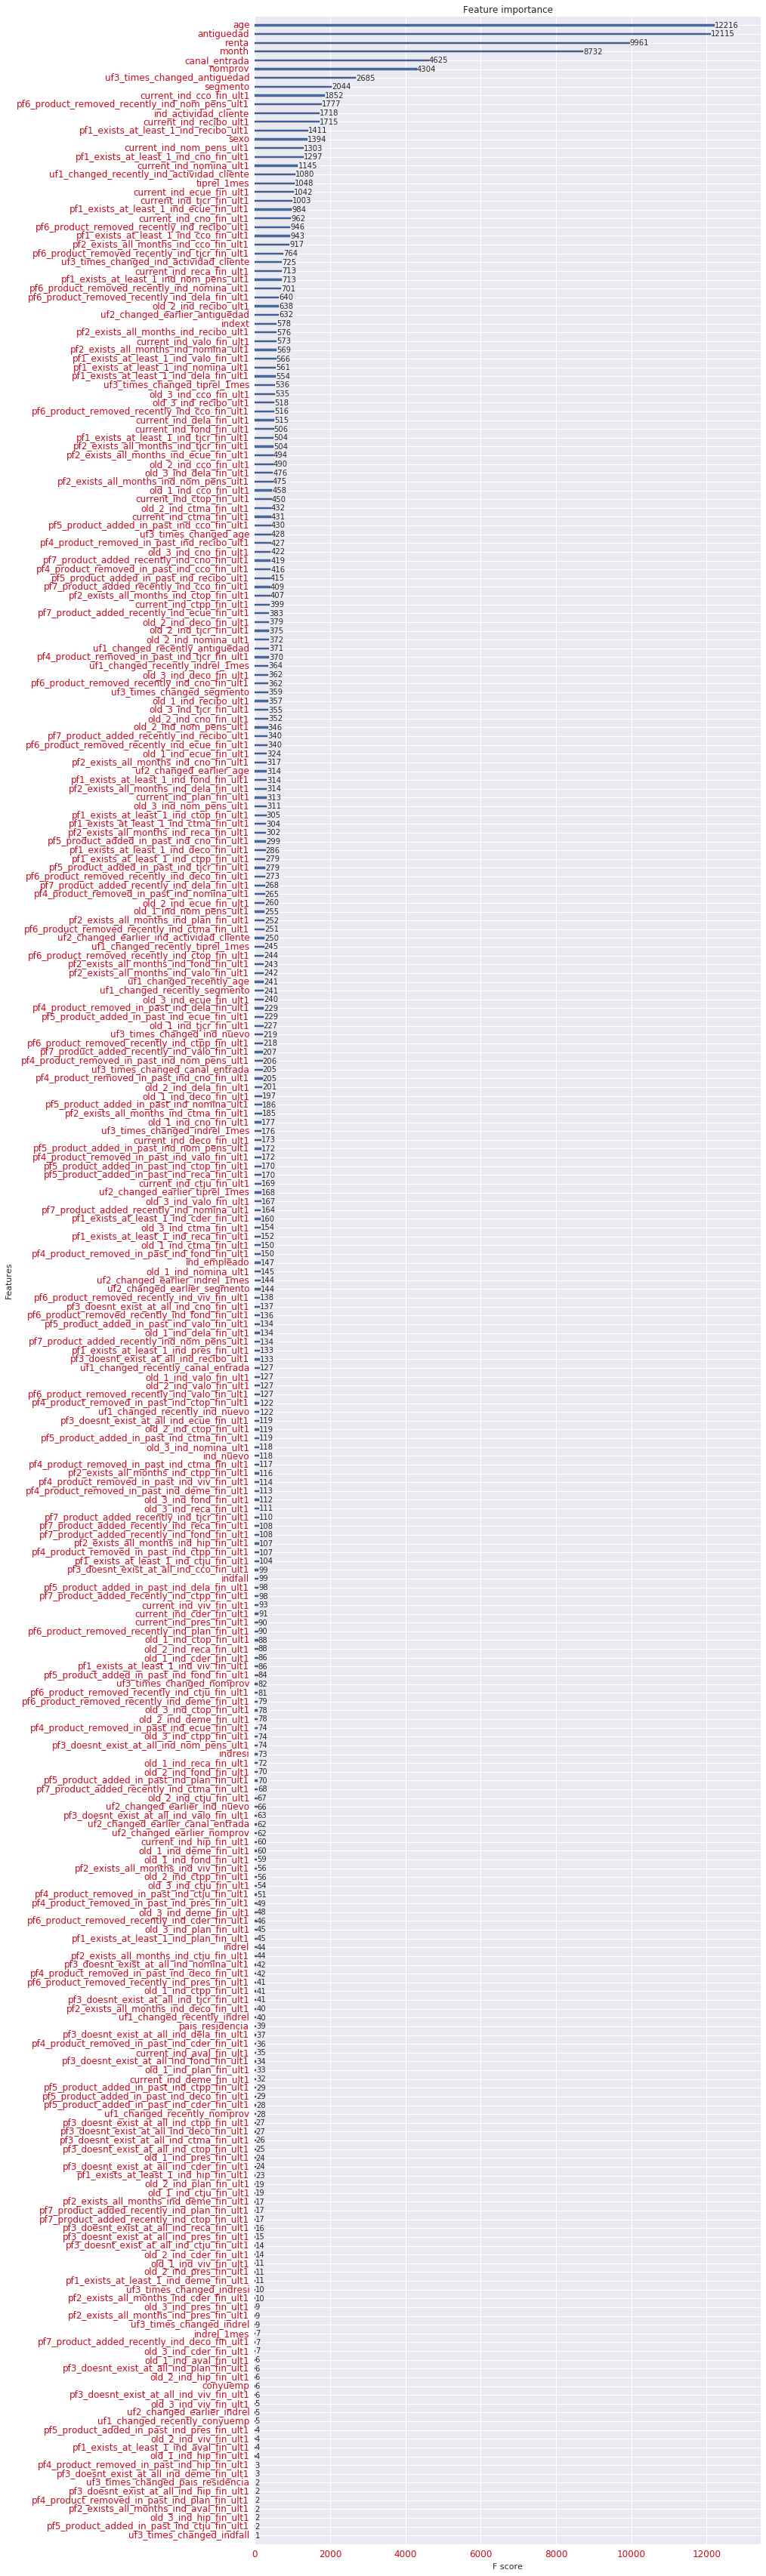

time: 5.49 s


In [64]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

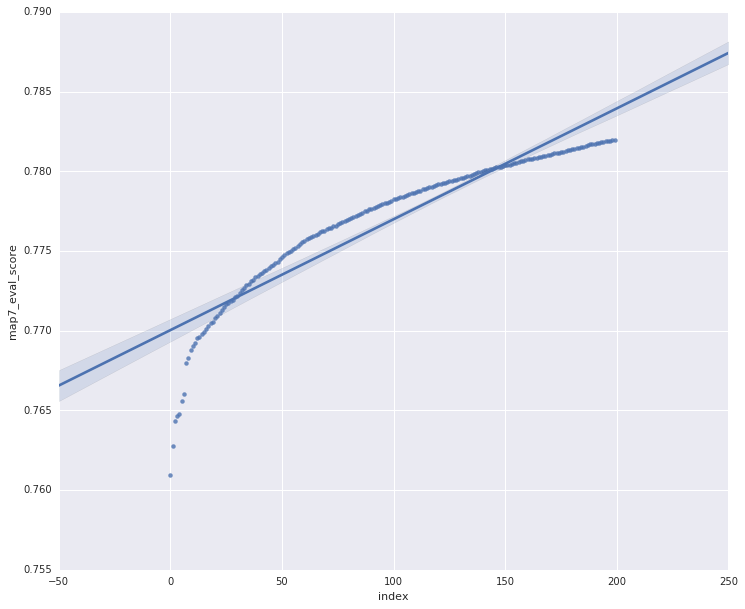

time: 329 ms


In [65]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [66]:
xgb_model.save_model('data/14.1.xgboost_model_save.xgb')
make_submission('data/14.1.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/14.1.xgboost_model_save.xgb.zip
uploading to s3 done
time: 810 ms


In [67]:
final_test = xgb.DMatrix(test)

preds = xgb_model.predict(final_test)

time: 48.5 s


In [68]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [13:41<00:00, 1131.67it/s]

time: 13min 44s


In [69]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.1.xgb_trained_on_all_months_user_attr_lags_subs_lags_and_no_attr_raw_lags.csv'
description = '14.1 (feature engineering was done in 13.)\
               without having the raw user attributes of older months\
               xgb model 200 iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.1.xgb_trained_on_all_months_user_attr_lags_subs_lags_and_no_attr_raw_lags.csv.zip
uploading to s3 done
Uploading submission data/14.1.xgb_trained_on_all_months_user_attr_lags_subs_lags_and_no_attr_raw_lags.csv.zip
Upload done
time: 20.9 s


In [70]:
pickle_description = '14.1 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.1.xgb_trained_on_all_months_user_attr_lags_subs_lags_and_no_attr_raw_lags.csv.pickle.zip
uploading to s3 done
time: 2min 9s


---
# remove the user attr changes
---

In [71]:
del test['xgb_preds'], test['added_products']

time: 97.8 ms


In [73]:
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

#  df.set_value(i, 'uf1_changed_recently_' + col, user_features[0])
#             df.set_value(i, 'uf2_changed_earlier_' + col, user_features[1])
#             df.set_value(i, 'uf3_times_changed_' + col, user_features[2])
for col in user_attributes:
    del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
    del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]

time: 43.6 s


In [74]:
print train.shape
print test.shape

(441652, 283)
(929615, 283)
time: 1.25 ms


In [77]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 250
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

time: 3.14 s


In [78]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.762594
[1]	train-MAP@7:0.761627
[2]	train-MAP@7:0.762813
[3]	train-MAP@7:0.763807
[4]	train-MAP@7:0.76431
[5]	train-MAP@7:0.765227
[6]	train-MAP@7:0.765338
[7]	train-MAP@7:0.766995
[8]	train-MAP@7:0.76726
[9]	train-MAP@7:0.767652
[10]	train-MAP@7:0.768159
[11]	train-MAP@7:0.76856
[12]	train-MAP@7:0.768791
[13]	train-MAP@7:0.768965
[14]	train-MAP@7:0.769275
[15]	train-MAP@7:0.76937
[16]	train-MAP@7:0.769427
[17]	train-MAP@7:0.769604
[18]	train-MAP@7:0.769787
[19]	train-MAP@7:0.769941
[20]	train-MAP@7:0.769998
[21]	train-MAP@7:0.770158
[22]	train-MAP@7:0.770349
[23]	train-MAP@7:0.770661
[24]	train-MAP@7:0.770849
[25]	train-MAP@7:0.770989
[26]	train-MAP@7:0.771207
[27]	train-MAP@7:0.771404
[28]	train-MAP@7:0.771542
[29]	train-MAP@7:0.771605
[30]	train-MAP@7:0.771773
[31]	train-MAP@7:0.771841
[32]	train-MAP@7:0.771947
[33]	train-MAP@7:0.772067
[34]	train-MAP@7:0.772208
[35]	train-MAP@7:0.77238
[36]	train-MAP@7:0.77252
[37]	train-MAP@7:0.772588
[38]	train-MAP@7:0.772688
[3

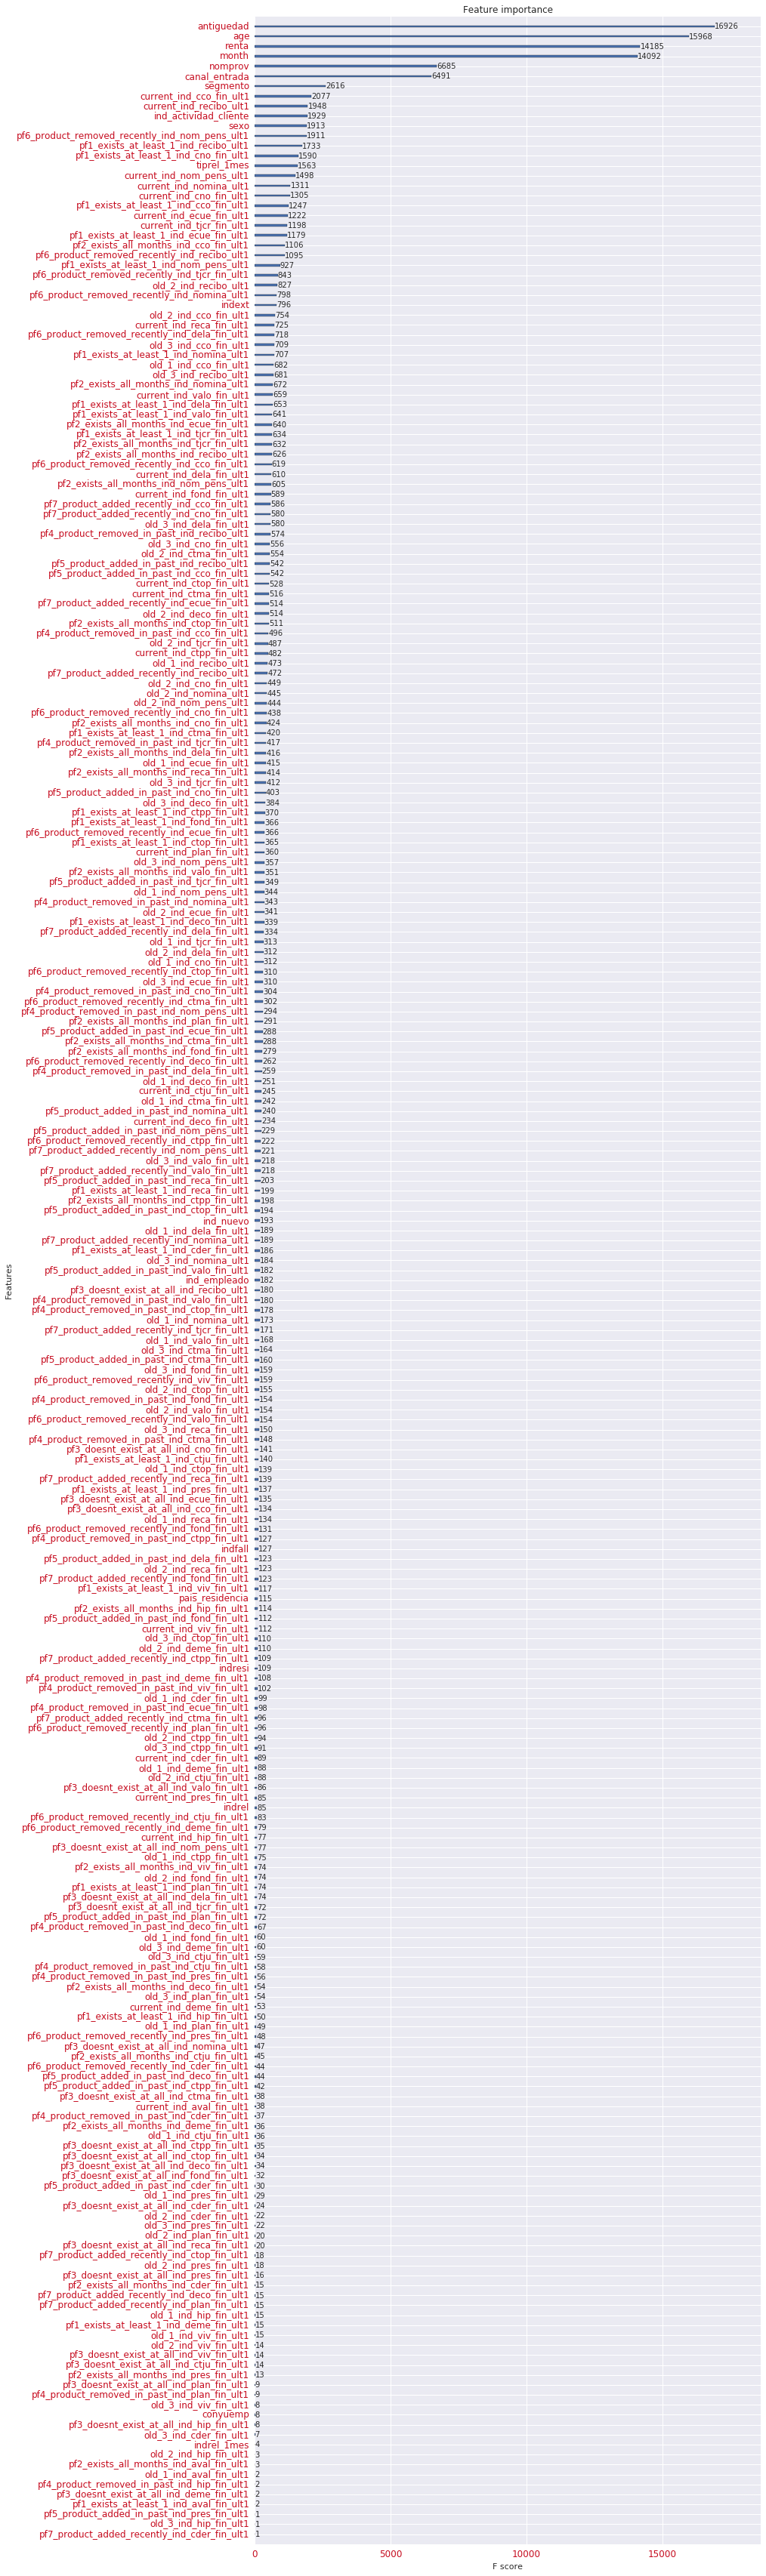

time: 4.93 s


In [79]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

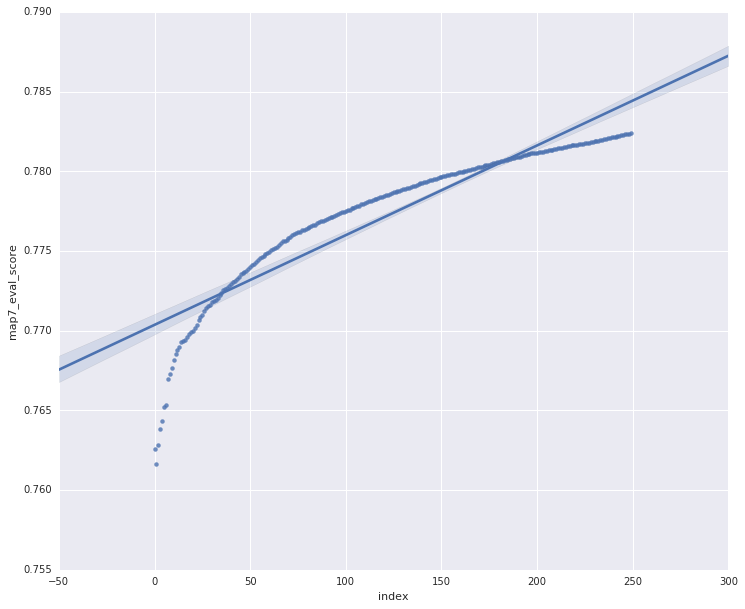

time: 309 ms


In [80]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [88]:
xgb_model.save_model('data/14.2.xgboost_model_save.xgb')
make_submission('data/14.2.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/14.2.xgboost_model_save.xgb.zip
uploading to s3 done
time: 10.3 s


In [83]:
final_test = xgb.DMatrix(test)

preds = xgb_model.predict(final_test)

time: 56.4 s


In [84]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
test.reset_index(inplace=True)
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)
test.set_index('ncodpers', inplace=True)

100%|██████████| 929615/929615 [12:57<00:00, 1195.51it/s]


time: 13min 1s


In [86]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.2.xgb_trained_on_all_months_subs_lags_250iters.csv'
description = '14.2 (feature engineering was done in 13.)\
               without having the raw user attributes of older months\
               removed user attribute change features also\
               xgb model 250 iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=False, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.2.xgb_trained_on_all_months_subs_lags_250iters.csv.zip
uploading to s3 done
time: 11.8 s


In [87]:
pickle_description = '14.2 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/14.2.xgb_trained_on_all_months_subs_lags_250iters.csv.pickle.zip
uploading to s3 done
time: 2min 5s


---
# Finding the optimum n_iter
---

In [100]:
def test_train_split_wt(df, wt_col, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n, weights=wt_col.apply(lambda x: wt_col.value_counts()[x])).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

def test_train_split(df, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

time: 6.91 ms


In [90]:
del test['xgb_preds'], test['added_products']

time: 31.6 ms


In [99]:
train.reset_index(inplace=True)
added_products.reset_index(inplace=True)

time: 4.9 ms


In [102]:
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 400
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 283) (22082, 3)
(419570, 283) (419570, 3)
time: 4.59 s


In [ ]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.759153	cv-MAP@7:0.754098
[1]	train-MAP@7:0.762409	cv-MAP@7:0.756725
[2]	train-MAP@7:0.763222	cv-MAP@7:0.75677
[3]	train-MAP@7:0.763799	cv-MAP@7:0.757631
[4]	train-MAP@7:0.764232	cv-MAP@7:0.757495
[5]	train-MAP@7:0.764447	cv-MAP@7:0.758219
[6]	train-MAP@7:0.767336	cv-MAP@7:0.76062
[7]	train-MAP@7:0.767674	cv-MAP@7:0.760665
[8]	train-MAP@7:0.767929	cv-MAP@7:0.760755
[9]	train-MAP@7:0.768346	cv-MAP@7:0.761389
[10]	train-MAP@7:0.768453	cv-MAP@7:0.760982
[11]	train-MAP@7:0.769016	cv-MAP@7:0.761344
[12]	train-MAP@7:0.769316	cv-MAP@7:0.761571
[13]	train-MAP@7:0.769426	cv-MAP@7:0.761525
[14]	train-MAP@7:0.769602	cv-MAP@7:0.762114
[15]	train-MAP@7:0.769826	cv-MAP@7:0.761933
[16]	train-MAP@7:0.769798	cv-MAP@7:0.762386
[17]	train-MAP@7:0.769972	cv-MAP@7:0.762703
[18]	train-MAP@7:0.770153	cv-MAP@7:0.762431
[19]	train-MAP@7:0.77025	cv-MAP@7:0.763065
[20]	train-MAP@7:0.77042	cv-MAP@7:0.762929
[21]	train-MAP@7:0.770653	cv-MAP@7:0.763065
[22]	train-MAP@7:0.770911	cv-MAP@7:0.763201
[2

In [ ]:
def get_n_iter_from_evals_results(evals_result):
    return n

optimal_n = int(n/0.95)

In [ ]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)

dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

In [ ]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_results=evals_result)

In [ ]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
test.reset_index(inplace=True)
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)
test.set_index('ncodpers', inplace=True)

In [ ]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/14.3.xgb_trained_on_all_months_subs_lags_tuned_n_iters.csv'
description = '14.3 (feature engineering was done in 13.)\
               without having the raw user attributes of older months\
               removed user attribute change features also\
               xgb model tuned itres iter trained on all months on added products and more features\
               features generated from last 4 months\
               user attr changes features:\
               user attribute changed recently, changed earlier, no of times changed in the past 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param) + " n iters " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=False, compress=True, upload_to_s3=True)

In [ ]:
pickle_description = '14.3 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)